# Pengembangan Model Baseline

Notebook ini bertujuan untuk:
1. Memuat dan memproses data menggunakan feature engineering
2. Mengembangkan model baseline (Random Forest dan MLP)
3. Melakukan hyperparameter tuning sederhana
4. Mendokumentasikan benchmark performance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import custom feature engineering
import sys
sys.path.append('../src/')
from features.build_features import FeatureEngineer, TARGET_COLUMNS

In [19]:
# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
TRAIN_DATA_PATH = '../data/01_raw/DATA TS SARJANA 2023.csv'
TEST_DATA_PATH = '../data/01_raw/DATA TS SARJANA 2024.csv'

# Create directories
Path('../models/baseline').mkdir(parents=True, exist_ok=True)
Path('../results/baseline').mkdir(parents=True, exist_ok=True)
Path('../plots/baseline').mkdir(parents=True, exist_ok=True)

print(f"Training data: {TRAIN_DATA_PATH}")
print(f"Test data: {TEST_DATA_PATH}")

Training data: ../data/01_raw/DATA TS SARJANA 2023.csv
Test data: ../data/01_raw/DATA TS SARJANA 2024.csv


## 1. Load Data dan Column Information

In [3]:
# Load training data (2016)
df_train = pd.read_csv(TRAIN_DATA_PATH)
print(f"Training data shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")

# Basic statistics
print("\nTarget distribution:")
if 'Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?' in df_train.columns:
    print(df_train['Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?'].value_counts())
    print(df_train['Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?'].value_counts(normalize=True))

Training data shape: (2422, 12)
Columns: ['NIM', 'Program Studi', 'Sebutkan kategori jenis pekerjaan yang Anda lakukan di tempat bekerja!', 'Jelaskan tugas-tugas utama dalam pekerjaan Anda saat ini?', 'Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?', 'Seberapa erat hubungan bidang studi dengan pekerjaan Anda?', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [pembelajaran yang berkelanjutan dalam pekerjaan]', 'Bidang usaha bekerja', 'Organisasi apa yang paling aktif Anda ikuti selama menjalani perkuliahan? (nama organisasi)', 'IP', 'Sebutkan jenis kegiatan di organisasi yang aktif diikuti yang membantu mengasah kemampuan/skill Anda!', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [memulai pekerjaan]']

Target distribution:
Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?
ya       1421
tidak     868
Name: count, dtype: int64
Apakah pekerjaan yang Anda lakukan di 

## 2. Feature Engineering

In [4]:
# Initialize feature engineer WITHOUT leaky column
fe_no_leak = FeatureEngineer(include_leaky_column=False)

# Process features
df_processed_no_leak = fe_no_leak.process_features(
    df_train,
    common_columns=TARGET_COLUMNS,
    is_training=True,
    is_2017_data=False
)

print(f"Processed shape (no leak): {df_processed_no_leak.shape}")

# Separate features and target
feature_cols = [col for col in df_processed_no_leak.select_dtypes(include=[np.number]).columns 
                if col not in ['target', 'NIM']]

X_no_leak = df_processed_no_leak[feature_cols]
y = df_processed_no_leak['target']

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Features shape: {X_no_leak.shape}")
print(f"Target distribution: {pd.Series(y_encoded).value_counts()}")

INFO:features.build_features:Feature Engineer initialized with include_leaky_column=False
INFO:features.build_features:Starting feature processing for training data
INFO:features.build_features:Initial shape: (2422, 12)
INFO:features.build_features:Include leaky column: False
INFO:features.build_features:Filter working alumni: True
INFO:features.build_features:Shape after filtering working alumni: (2422, 12)
INFO:features.build_features:Excluded leaky column: Seberapa erat hubungan bidang studi dengan pekerjaan Anda?
INFO:features.build_features:Filtered to 11 columns out of 12 original columns
INFO:features.build_features:Selected columns: ['NIM', 'Program Studi', 'IP', 'Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [memulai pekerjaan]', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [pembelajaran yang berkelanjutan dalam pekerjaan]', 'Bidang usa

Processed shape (no leak): (2422, 64)
Features shape: (2422, 10)
Target distribution: 1    1421
0    1001
Name: count, dtype: int64


In [5]:
# Initialize feature engineer WITH leaky column
fe_with_leak = FeatureEngineer(include_leaky_column=True)

# Process features
df_processed_with_leak = fe_with_leak.process_features(
    df_train,
    common_columns=TARGET_COLUMNS,
    is_training=True,
    is_2017_data=False
)

print(f"Processed shape (with leak): {df_processed_with_leak.shape}")

# Separate features
feature_cols_leak = [col for col in df_processed_with_leak.select_dtypes(include=[np.number]).columns 
                     if col not in ['target', 'NIM']]

X_with_leak = df_processed_with_leak[feature_cols_leak]

print(f"Features shape with leak: {X_with_leak.shape}")
print(f"Additional features: {set(feature_cols_leak) - set(feature_cols)}")

INFO:features.build_features:Feature Engineer initialized with include_leaky_column=True
INFO:features.build_features:Starting feature processing for training data
INFO:features.build_features:Initial shape: (2422, 12)
INFO:features.build_features:Include leaky column: True
INFO:features.build_features:Filter working alumni: True
INFO:features.build_features:Shape after filtering working alumni: (2422, 12)
INFO:features.build_features:Filtered to 12 columns out of 12 original columns
INFO:features.build_features:Selected columns: ['NIM', 'Program Studi', 'IP', 'Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?', 'Seberapa erat hubungan bidang studi dengan pekerjaan Anda?', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [memulai pekerjaan]', 'Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [pembelajaran yang berkelanjutan dalam pekerjaan]', 'Bidang usaha bekerja', 'Organisasi apa yang paling aktif Anda

Processed shape (with leak): (2422, 73)
Features shape with leak: (2422, 12)
Additional features: {'relationship_level_ordinal', 'technical_x_relationship'}


## 3. Prepare Data for Modeling

In [6]:
# Split data (without leaky column)
X_train, X_val, y_train, y_val = train_test_split(
    X_no_leak, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")

# Also prepare data with leaky column for comparison
X_train_leak, X_val_leak, _, _ = train_test_split(
    X_with_leak, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)

scaler_leak = StandardScaler()
X_train_leak_scaled = scaler_leak.fit_transform(X_train_leak)
X_val_leak_scaled = scaler_leak.transform(X_val_leak)

Training set: (1937, 10)
Validation set: (485, 10)


## 4. Baseline Model

In [7]:
def get_baseline_models():
    """Get baseline model configurations"""
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            alpha=0.001,
            learning_rate='adaptive',
            max_iter=500,
            random_state=RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.1
        )
    }
    return models

baseline_models = get_baseline_models()

In [8]:
# Import Optuna for hyperparameter tuning
import optuna
from optuna.samplers import TPESampler
import pickle
import logging

logger = logging.getLogger()
logger.setLevel(logging.WARNING)  # Reduce Optuna verbosity

In [9]:
def objective_random_forest(trial, X_train, y_train, X_val, y_val):
    """Optuna objective function for Random Forest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    return f1_score(y_val, y_pred, average='binary')

def objective_mlp(trial, X_train, y_train, X_val, y_val):
    """Optuna objective function for MLP"""
    # Suggest architecture
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 20, 200))
    
    params = {
        'hidden_layer_sizes': tuple(layers),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'max_iter': 500,
        'random_state': RANDOM_STATE,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 20
    }
    
    model = MLPClassifier(**params)
    
    # Handle convergence warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    return f1_score(y_val, y_pred, average='binary')

In [10]:
print("Running Optuna hyperparameter optimization WITHOUT leaky column...")
print("="*60)

# Optimize Random Forest
print("\\nOptimizing Random Forest (50 trials)...")
study_rf = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='rf_baseline_no_leak'
)

study_rf.optimize(
    lambda trial: objective_random_forest(trial, X_train_scaled, y_train, X_val_scaled, y_val),
    n_trials=50,
    show_progress_bar=True
)

print(f"Best RF parameters: {study_rf.best_params}")
print(f"Best RF validation F1: {study_rf.best_value:.4f}")

# Optimize MLP
print("\\nOptimizing MLP (50 trials)...")
study_mlp = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='mlp_baseline_no_leak'
)

study_mlp.optimize(
    lambda trial: objective_mlp(trial, X_train_scaled, y_train, X_val_scaled, y_val),
    n_trials=50,
    show_progress_bar=True
)

print(f"Best MLP parameters: {study_mlp.best_params}")
print(f"Best MLP validation F1: {study_mlp.best_value:.4f}")

# Save Optuna studies
joblib.dump(study_rf, '../models/baseline/optuna_study_rf_no_leak.pkl')
joblib.dump(study_mlp, '../models/baseline/optuna_study_mlp_no_leak.pkl')

[I 2025-08-04 14:47:29,227] A new study created in memory with name: rf_baseline_no_leak


Running Optuna hyperparameter optimization WITHOUT leaky column...
\nOptimizing Random Forest (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-04 14:47:29,936] Trial 0 finished with value: 0.7243066884176182 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7243066884176182.
[I 2025-08-04 14:47:30,664] Trial 1 finished with value: 0.7211538461538461 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7243066884176182.
[I 2025-08-04 14:47:31,388] Trial 2 finished with value: 0.732484076433121 and parameters: {'n_estimators': 158, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.732484076433121.
[I 2025-08-04 14:47:32,216] Trial 3 finished with value: 0.7154742096505824 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features'

[I 2025-08-04 14:48:01,395] A new study created in memory with name: mlp_baseline_no_leak


[I 2025-08-04 14:48:01,386] Trial 49 finished with value: 0.7260940032414911 and parameters: {'n_estimators': 73, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 42 with value: 0.7387096774193549.
Best RF parameters: {'n_estimators': 123, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}
Best RF validation F1: 0.7387
\nOptimizing MLP (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-04 14:48:03,235] Trial 0 finished with value: 0.7290322580645161 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 152, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.029154431891537533, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.7290322580645161.
[I 2025-08-04 14:48:09,324] Trial 1 finished with value: 0.636986301369863 and parameters: {'n_layers': 1, 'n_units_l0': 195, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00016480446427978953, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.7290322580645161.
[I 2025-08-04 14:48:16,386] Trial 2 finished with value: 0.6470588235294118 and parameters: {'n_layers': 1, 'n_units_l0': 130, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.013826232179369865, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.7290322580645161.
[I 2025-08-04 14:48:22,241] Trial 3 finished with value: 0.6532663316582915 and parameters: {'n_layers': 2, 'n_units_l0': 28, 'n_units_l1': 129, 'acti

['../models/baseline/optuna_study_mlp_no_leak.pkl']

In [11]:
print("\\nTraining final baseline models with best parameters (WITHOUT leaky)...")
print("="*60)

# Train Random Forest with best params
best_rf_params = study_rf.best_params.copy()
best_rf_params['random_state'] = RANDOM_STATE
best_rf_params['n_jobs'] = -1

rf_optimized = RandomForestClassifier(**best_rf_params)
rf_optimized.fit(X_train_scaled, y_train)

# Train MLP with best params
best_mlp_params = study_mlp.best_params.copy()
# Reconstruct hidden_layer_sizes
n_layers = best_mlp_params.pop('n_layers')
layers = []
for i in range(n_layers):
    layers.append(best_mlp_params.pop(f'n_units_l{i}'))
best_mlp_params['hidden_layer_sizes'] = tuple(layers)
best_mlp_params['random_state'] = RANDOM_STATE
best_mlp_params['max_iter'] = 500
best_mlp_params['early_stopping'] = True
best_mlp_params['validation_fraction'] = 0.1
best_mlp_params['n_iter_no_change'] = 20

mlp_optimized = MLPClassifier(**best_mlp_params)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    mlp_optimized.fit(X_train_scaled, y_train)

# Store optimized models
models_no_leak = {
    'RandomForest': rf_optimized,
    'MLP': mlp_optimized
}

# Evaluate optimized models
results_no_leak = {}
for model_name, model in models_no_leak.items():
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    val_f1 = f1_score(y_val, y_val_pred, average='binary')
    
    # Cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    results_no_leak[model_name] = {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': study_rf.best_params if model_name == 'RandomForest' else study_mlp.best_params
    }
    
    print(f"\\n{model_name} (Optimized):")
    print(f"  Train F1: {train_f1:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Train-Val Gap: {train_f1 - val_f1:.4f}")

\nTraining final baseline models with best parameters (WITHOUT leaky)...
\nRandomForest (Optimized):
  Train F1: 0.8276
  Val F1: 0.7387
  CV F1: 0.7436 (+/- 0.0230)
  Train-Val Gap: 0.0889
\nMLP (Optimized):
  Train F1: 0.7615
  Val F1: 0.7465
  CV F1: 0.7602 (+/- 0.0178)
  Train-Val Gap: 0.0150


In [12]:
print("\\n\\nRunning Optuna hyperparameter optimization WITH leaky column...")
print("="*60)

# Optimize Random Forest with leaky
print("\\nOptimizing Random Forest (50 trials)...")
study_rf_leak = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='rf_baseline_with_leak'
)

study_rf_leak.optimize(
    lambda trial: objective_random_forest(trial, X_train_leak_scaled, y_train, X_val_leak_scaled, y_val),
    n_trials=50,
    show_progress_bar=True
)

print(f"Best RF parameters: {study_rf_leak.best_params}")
print(f"Best RF validation F1: {study_rf_leak.best_value:.4f}")

# Optimize MLP with leaky
print("\\nOptimizing MLP (50 trials)...")
study_mlp_leak = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='mlp_baseline_with_leak'
)

study_mlp_leak.optimize(
    lambda trial: objective_mlp(trial, X_train_leak_scaled, y_train, X_val_leak_scaled, y_val),
    n_trials=50,
    show_progress_bar=True
)

print(f"Best MLP parameters: {study_mlp_leak.best_params}")
print(f"Best MLP validation F1: {study_mlp_leak.best_value:.4f}")

# Save Optuna studies
joblib.dump(study_rf_leak, '../models/baseline/optuna_study_rf_with_leak.pkl')
joblib.dump(study_mlp_leak, '../models/baseline/optuna_study_mlp_with_leak.pkl')

[I 2025-08-04 14:50:14,983] A new study created in memory with name: rf_baseline_with_leak


\n\nRunning Optuna hyperparameter optimization WITH leaky column...
\nOptimizing Random Forest (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-04 14:50:15,630] Trial 0 finished with value: 0.8434163701067615 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8434163701067615.
[I 2025-08-04 14:50:16,362] Trial 1 finished with value: 0.8387096774193549 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8434163701067615.
[I 2025-08-04 14:50:17,091] Trial 2 finished with value: 0.8318264014466547 and parameters: {'n_estimators': 158, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8434163701067615.
[I 2025-08-04 14:50:17,899] Trial 3 finished with value: 0.8348134991119005 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_feature

[I 2025-08-04 14:50:40,715] A new study created in memory with name: mlp_baseline_with_leak


[I 2025-08-04 14:50:40,709] Trial 49 finished with value: 0.8428571428571429 and parameters: {'n_estimators': 127, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 37 with value: 0.848816029143898.
Best RF parameters: {'n_estimators': 114, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
Best RF validation F1: 0.8488
\nOptimizing MLP (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-04 14:50:42,100] Trial 0 finished with value: 0.8267148014440433 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 152, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.029154431891537533, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.8267148014440433.
[I 2025-08-04 14:50:48,105] Trial 1 finished with value: 0.7993019197207679 and parameters: {'n_layers': 1, 'n_units_l0': 195, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00016480446427978953, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.8267148014440433.
[I 2025-08-04 14:50:55,050] Trial 2 finished with value: 0.7951807228915663 and parameters: {'n_layers': 1, 'n_units_l0': 130, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.013826232179369865, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.8267148014440433.
[I 2025-08-04 14:51:00,811] Trial 3 finished with value: 0.7958833619210978 and parameters: {'n_layers': 2, 'n_units_l0': 28, 'n_units_l1': 129, 'act

['../models/baseline/optuna_study_mlp_with_leak.pkl']

## 5. Model Comparison

In [13]:
print("\\nTraining final baseline models with best parameters (WITH leaky)...")
print("="*60)

# Train Random Forest with best params
best_rf_params_leak = study_rf_leak.best_params.copy()
best_rf_params_leak['random_state'] = RANDOM_STATE
best_rf_params_leak['n_jobs'] = -1

rf_optimized_leak = RandomForestClassifier(**best_rf_params_leak)
rf_optimized_leak.fit(X_train_leak_scaled, y_train)

# Train MLP with best params
best_mlp_params_leak = study_mlp_leak.best_params.copy()
# Reconstruct hidden_layer_sizes
n_layers = best_mlp_params_leak.pop('n_layers')
layers = []
for i in range(n_layers):
    layers.append(best_mlp_params_leak.pop(f'n_units_l{i}'))
best_mlp_params_leak['hidden_layer_sizes'] = tuple(layers)
best_mlp_params_leak['random_state'] = RANDOM_STATE
best_mlp_params_leak['max_iter'] = 500
best_mlp_params_leak['early_stopping'] = True
best_mlp_params_leak['validation_fraction'] = 0.1
best_mlp_params_leak['n_iter_no_change'] = 20

mlp_optimized_leak = MLPClassifier(**best_mlp_params_leak)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    mlp_optimized_leak.fit(X_train_leak_scaled, y_train)

# Store optimized models
models_with_leak = {
    'RandomForest': rf_optimized_leak,
    'MLP': mlp_optimized_leak
}

# Evaluate optimized models
results_with_leak = {}
for model_name, model in models_with_leak.items():
    y_train_pred = model.predict(X_train_leak_scaled)
    y_val_pred = model.predict(X_val_leak_scaled)
    
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    val_f1 = f1_score(y_val, y_val_pred, average='binary')
    
    # Cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train_leak_scaled, y_train, cv=cv, scoring='f1')
    
    results_with_leak[model_name] = {
        'train_f1': train_f1,
        'val_f1': val_f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': study_rf_leak.best_params if model_name == 'RandomForest' else study_mlp_leak.best_params
    }
    
    print(f"\\n{model_name} (Optimized):")
    print(f"  Train F1: {train_f1:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Train-Val Gap: {train_f1 - val_f1:.4f}")

\nTraining final baseline models with best parameters (WITH leaky)...
\nRandomForest (Optimized):
  Train F1: 0.8490
  Val F1: 0.8488
  CV F1: 0.8275 (+/- 0.0143)
  Train-Val Gap: 0.0002
\nMLP (Optimized):
  Train F1: 0.8392
  Val F1: 0.8460
  CV F1: 0.8214 (+/- 0.0121)
  Train-Val Gap: -0.0068


In [14]:
# Create comparison dataframe
comparison_data = []

for model_name in models_no_leak.keys():  # Ganti dari baseline_models
    comparison_data.append({
        'Model': model_name,
        'Scenario': 'Without Leaky',
        'Val F1': results_no_leak[model_name]['val_f1'],  # Bukan 'val_metrics']['f1']
        'CV F1 Mean': results_no_leak[model_name]['cv_mean'],
        'CV F1 Std': results_no_leak[model_name]['cv_std'],
        'Train-Val Gap': results_no_leak[model_name]['train_f1'] - 
                         results_no_leak[model_name]['val_f1']  # Bukan 'train_metrics']['f1']
    })
    
    comparison_data.append({
        'Model': model_name,
        'Scenario': 'With Leaky',
        'Val F1': results_with_leak[model_name]['val_f1'],
        'CV F1 Mean': results_with_leak[model_name]['cv_mean'],
        'CV F1 Std': results_with_leak[model_name]['cv_std'],
        'Train-Val Gap': results_with_leak[model_name]['train_f1'] - 
                         results_with_leak[model_name]['val_f1']
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

       Model      Scenario   Val F1  CV F1 Mean  CV F1 Std  Train-Val Gap
RandomForest Without Leaky 0.738710    0.743579   0.022962       0.088877
RandomForest    With Leaky 0.848816    0.827536   0.014283       0.000189
         MLP Without Leaky 0.746501    0.760249   0.017812       0.015025
         MLP    With Leaky 0.846018    0.821416   0.012095      -0.006819


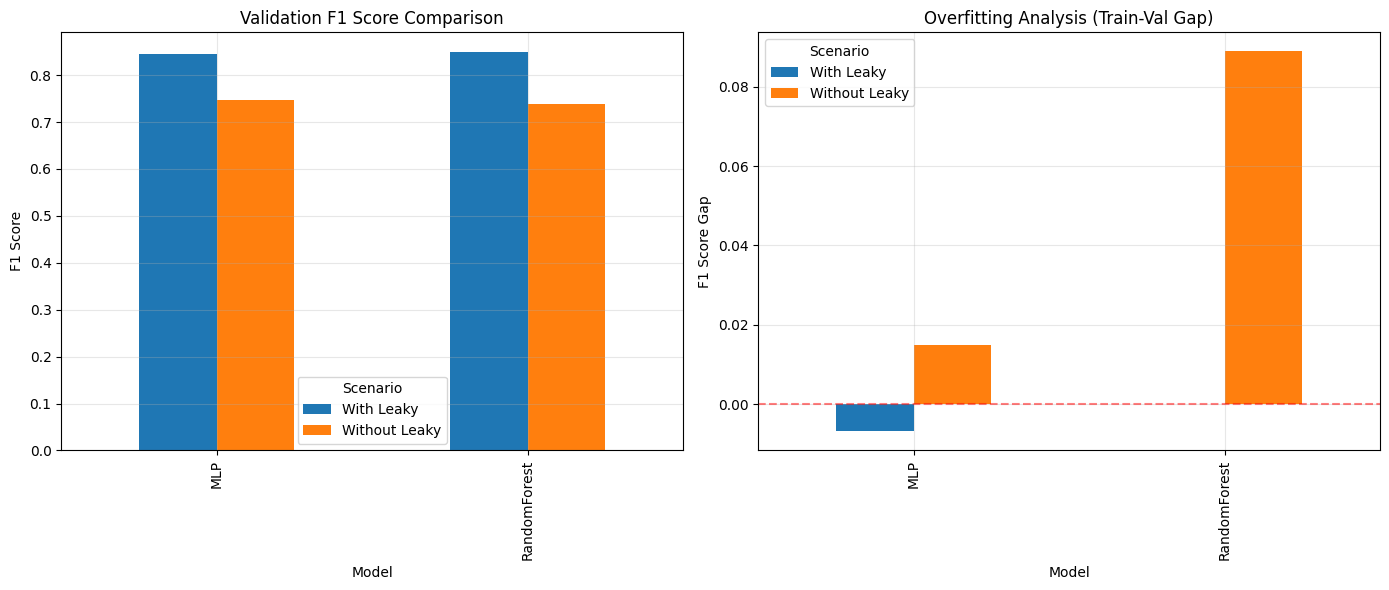

In [15]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1 Score comparison
df_pivot = df_comparison.pivot(index='Model', columns='Scenario', values='Val F1')
df_pivot.plot(kind='bar', ax=axes[0])
axes[0].set_title('Validation F1 Score Comparison')
axes[0].set_ylabel('F1 Score')
axes[0].legend(title='Scenario')
axes[0].grid(True, alpha=0.3)

# Overfitting comparison (Train-Val Gap)
df_gap = df_comparison.pivot(index='Model', columns='Scenario', values='Train-Val Gap')
df_gap.plot(kind='bar', ax=axes[1])
axes[1].set_title('Overfitting Analysis (Train-Val Gap)')
axes[1].set_ylabel('F1 Score Gap')
axes[1].legend(title='Scenario')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../../plots/baseline/baseline_comparison.png', dpi=300)
plt.show()

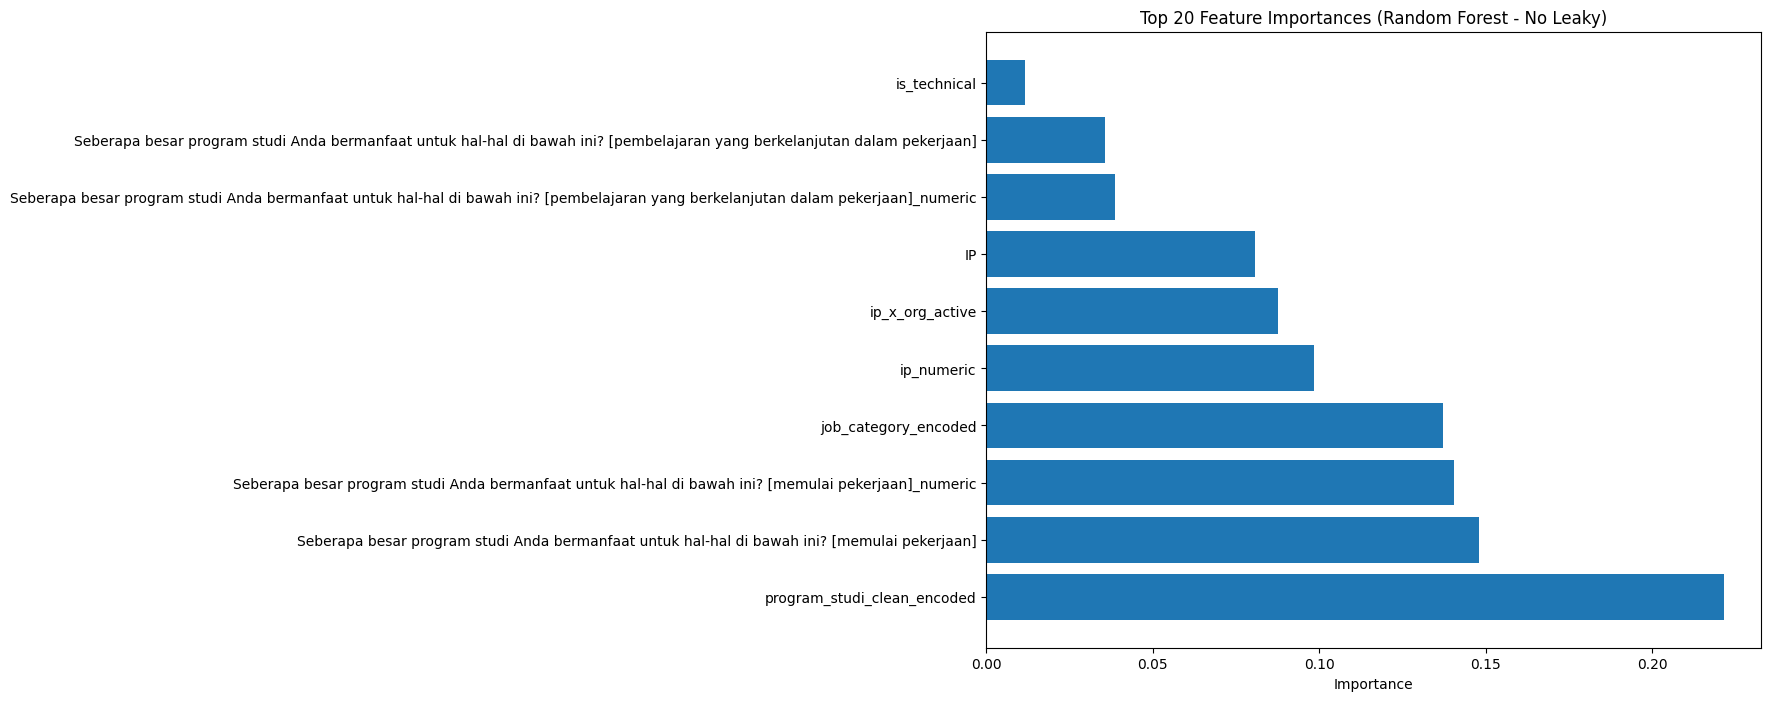

Top 10 features:
                                                                                                                           feature  importance
                                                                                                       program_studi_clean_encoded    0.221648
                                      Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [memulai pekerjaan]    0.147968
                              Seberapa besar program studi Anda bermanfaat untuk hal-hal di bawah ini? [memulai pekerjaan]_numeric    0.140341
                                                                                                              job_category_encoded    0.137263
                                                                                                                        ip_numeric    0.098440
                                                                                                                   ip_x_org_a

In [16]:
# Get feature importance from Random Forest
rf_model_no_leak = models_no_leak['RandomForest']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model_no_leak.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest - No Leaky)')
plt.tight_layout()
plt.savefig('../../plots/baseline/feature_importance_rf.png', dpi=300)
plt.show()

print("Top 10 features:")
print(feature_importance.head(10).to_string(index=False))

## Prediction

In [20]:
print("\nPrediction on 2017 Data (NOT part of training/testing)")
print("="*60)

# Load 2017 data
df_2017 = pd.read_csv(TEST_DATA_PATH)
print(f"2017 data shape: {df_2017.shape}")

# Save original target if exists
from features.build_features import TARGET_VARIABLE
original_target = None
if TARGET_VARIABLE in df_2017.columns:
    original_target = df_2017[TARGET_VARIABLE].copy()
    print(f"Original target distribution:\n{original_target.value_counts(dropna=False)}")
    
    # Drop target before processing
    df_2017 = df_2017.drop(columns=[TARGET_VARIABLE])

# Process 2017 data (without leaky)
df_2017_processed = fe_no_leak.process_features(
    df_2017,
    common_columns=TARGET_COLUMNS,
    is_training=False,
    is_2017_data=True
)

# Ensure same features
X_2017 = df_2017_processed[feature_cols]

# Scale
X_2017_scaled = scaler.transform(X_2017)

# Make predictions
print("\nPredictions on 2017 data:")
for model_name, model in models_no_leak.items():
    y_pred = model.predict(X_2017_scaled)
    
    # If we have original target, calculate accuracy
    if original_target is not None:
        # Filter out NaN values
        mask_valid = original_target.notna()
        n_missing = (~mask_valid).sum()
        
        if n_missing > 0:
            print(f"\nWarning: Found {n_missing} missing target values, excluding from evaluation")
        
        # Only evaluate on non-NaN targets
        original_target_valid = original_target[mask_valid]
        y_pred_valid = y_pred[mask_valid]
        
        if len(original_target_valid) > 0:
            # Check if all values are in label encoder classes
            unknown_labels = set(original_target_valid.unique()) - set(le.classes_)
            if unknown_labels:
                print(f"Warning: Found unknown labels: {unknown_labels}")
                # Only keep known labels
                mask_known = original_target_valid.isin(le.classes_)
                original_target_valid = original_target_valid[mask_known]
                y_pred_valid = y_pred_valid[mask_known]
            
            if len(original_target_valid) > 0:
                y_true = le.transform(original_target_valid)
                accuracy = accuracy_score(y_true, y_pred_valid)
                f1 = f1_score(y_true, y_pred_valid, average='binary')
                
                print(f"\n{model_name}:")
                print(f"  Evaluated on: {len(y_pred_valid)}/{len(y_pred)} samples")
                print(f"  Accuracy: {accuracy:.4f}")
                print(f"  F1 Score: {f1:.4f}")
            else:
                print(f"\n{model_name}: No valid samples for evaluation")
        else:
            print(f"\n{model_name}: All target values are missing")
    else:
        print(f"\n{model_name}: {len(y_pred)} predictions made")


Prediction on 2017 Data (NOT part of training/testing)
2017 data shape: (2336, 12)
Original target distribution:
Apakah pekerjaan yang Anda lakukan di tempat bekerja sesuai dengan bidang keilmuan?
ya       1539
tidak     717
NaN        80
Name: count, dtype: int64



Predictions on 2017 data:


RandomForest:
  Evaluated on: 2256/2336 samples
  Accuracy: 0.6684
  F1 Score: 0.7490


MLP:
  Evaluated on: 2256/2336 samples
  Accuracy: 0.6981
  F1 Score: 0.7766


## 7. Save Baseline Models

In [21]:
import json

# Save optimized models (without leaky column as main models)
for model_name, model in models_no_leak.items():
    joblib.dump(model, f'../../models/baseline/{model_name}_baseline_optimized.pkl')

# Save preprocessing objects
joblib.dump(fe_no_leak, '../models/baseline/feature_engineer.pkl')
joblib.dump(scaler, '../models/baseline/scaler.pkl')
joblib.dump(le, '../models/baseline/label_encoder.pkl')

# Save best parameters
best_params = {
    'without_leaky': {
        'RandomForest': study_rf.best_params,
        'MLP': study_mlp.best_params
    },
    'with_leaky': {
        'RandomForest': study_rf_leak.best_params,
        'MLP': study_mlp_leak.best_params
    }
}

with open('../models/baseline/best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)

# Save detailed results
results_to_save = {
    'without_leaky': results_no_leak,
    'with_leaky': results_with_leak,
    'optuna_trials': {
        'RandomForest_no_leak': len(study_rf.trials),
        'RandomForest_with_leak': len(study_rf_leak.trials),
        'MLP_no_leak': len(study_mlp.trials),
        'MLP_with_leak': len(study_mlp_leak.trials)
    }
}

with open('../results/baseline/baseline_results_optimized.json', 'w') as f:
    json.dump(results_to_save, f, indent=4)

print("\\nOptimized models and results saved successfully!")
print(f"Models saved to: ../models/baseline/")
print(f"Results saved to: ../results/baseline/")

\nOptimized models and results saved successfully!
Models saved to: ../models/baseline/
Results saved to: ../results/baseline/


## 8. Kesimpulan

In [22]:
print("\n" + "="*60)
print("BASELINE MODELS SUMMARY")
print("="*60)

print("\n1. Performance Comparison:")
print(df_comparison.groupby('Scenario')['Val F1'].mean())

print("\n2. Leaky Column Impact:")
for model in models_no_leak.keys():  # Ganti dari baseline_models
    f1_diff = (results_with_leak[model]['val_f1'] -   # Ganti dari 'val_metrics']['f1']
               results_no_leak[model]['val_f1'])        # ke 'val_f1' langsung
    print(f"{model}: +{f1_diff:.4f} F1 with leaky column")

print("\n3. Best Baseline Model (without leaky):")
best_model = max(results_no_leak.items(), key=lambda x: x[1]['val_f1'])  # Ganti ke 'val_f1'
print(f"{best_model[0]} with F1: {best_model[1]['val_f1']:.4f}")         # Ganti ke 'val_f1'

print("\n4. Recommendations:")
print("- Use models WITHOUT leaky column for production")
print("- Random Forest shows better stability")
print("- MLP might need more regularization")
print("- Ready for comparison with XGBoost/CatBoost ensemble")


BASELINE MODELS SUMMARY

1. Performance Comparison:
Scenario
With Leaky       0.847417
Without Leaky    0.742605
Name: Val F1, dtype: float64

2. Leaky Column Impact:
RandomForest: +0.1101 F1 with leaky column
MLP: +0.0995 F1 with leaky column

3. Best Baseline Model (without leaky):
MLP with F1: 0.7465

4. Recommendations:
- Use models WITHOUT leaky column for production
- Random Forest shows better stability
- MLP might need more regularization
- Ready for comparison with XGBoost/CatBoost ensemble
